# Hourly Time Series Forecasting using XGBoost

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
pjme = pd.read_csv('../input/PJME_hourly.csv', index_col=[0], parse_dates=[0])

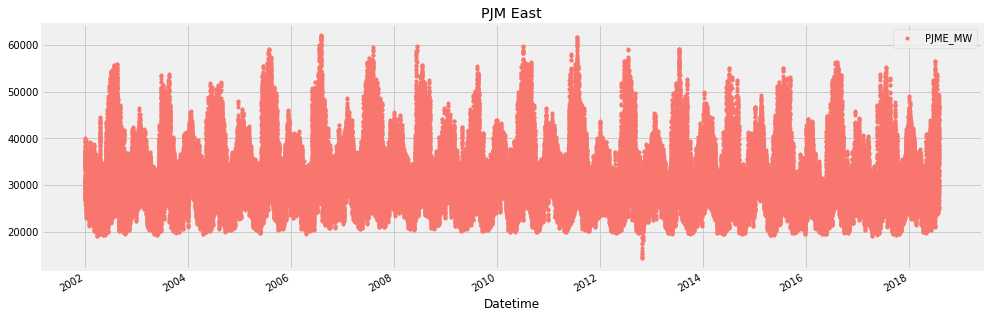

In [3]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [4]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

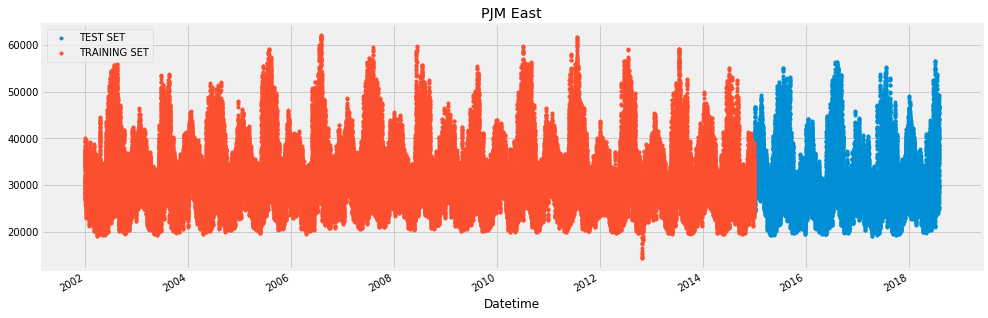

In [5]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

In [6]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [7]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

In [8]:
reg = xgb.XGBRegressor(n_estimators=1234,max_depth=7,gamma=1,learning_rate=0.113)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:29250.6	validation_1-rmse:28302.7
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:25993.7	validation_1-rmse:25041.7
[2]	validation_0-rmse:23109.2	validation_1-rmse:22167.5
[3]	validation_0-rmse:20554.9	validation_1-rmse:19630.9
[4]	validation_0-rmse:18294.8	validation_1-rmse:17411.2
[5]	validation_0-rmse:16296.2	validation_1-rmse:15448
[6]	validation_0-rmse:14530.3	validation_1-rmse:13706.7
[7]	validation_0-rmse:12969.8	validation_1-rmse:12220.6
[8]	validation_0-rmse:11595.8	validation_1-rmse:10903.3
[9]	validation_0-rmse:10383	validation_1-rmse:9789.66
[10]	validation_0-rmse:9316.62	validation_1-rmse:8789.02
[11]	validation_0-rmse:8381.73	validation_1-rmse:7921.92
[12]	validation_0-rmse:7563.02	validation_1-rmse:7160.42
[13]	validation_0-rmse:6847.48	validation_1-rmse:6552.48
[14]	validation_0-rmse:6228.69	validation_1-rmse:6002.34

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.113, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=1234,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

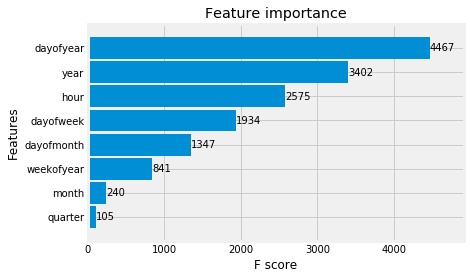

In [9]:
_ = plot_importance(reg, height=0.9)

In [10]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

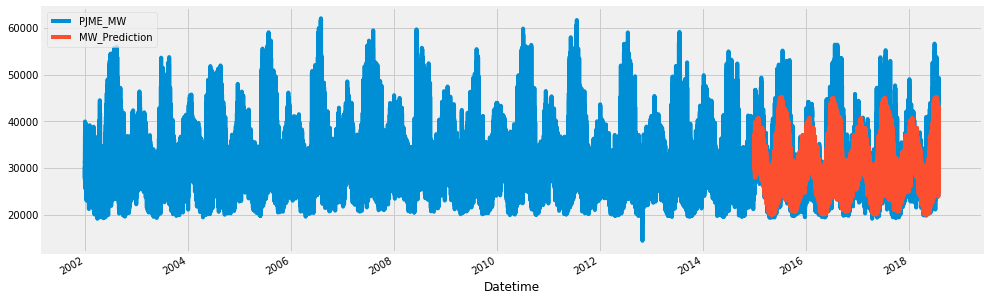

In [11]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

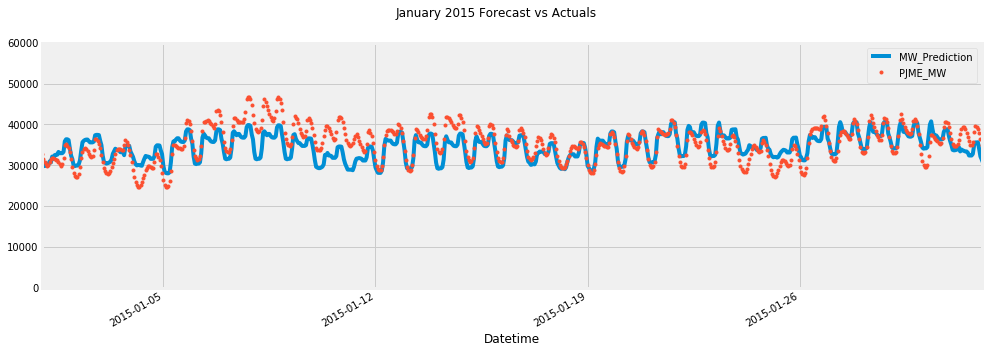

In [12]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

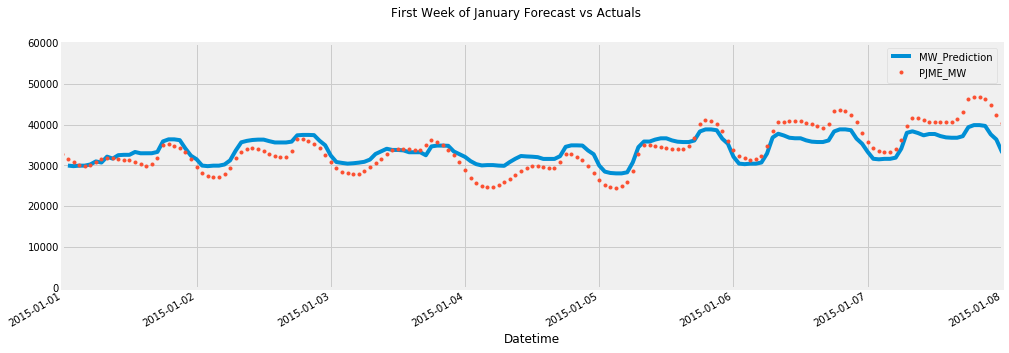

In [13]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

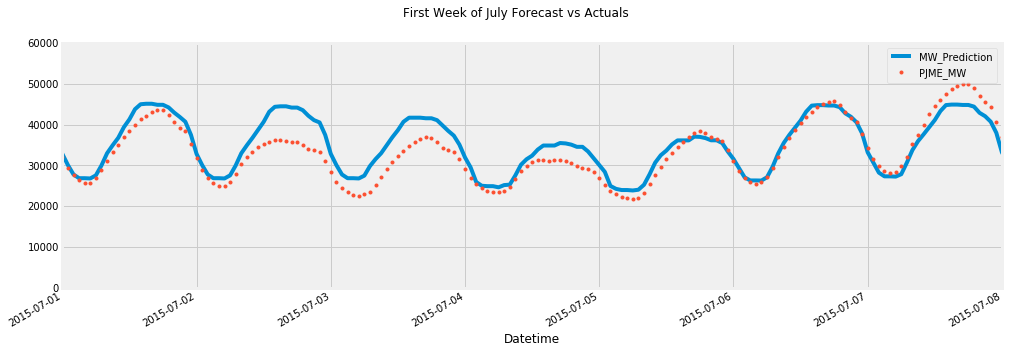

In [14]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

# Error Metrics On Test Set
Our RMSE error is 13780445  
Our MAE error is 2848.89  
Our MAPE error is 8.9%

In [15]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

14330308.960319687

In [16]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2745.0876037972344

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

8.374427704925285

In [19]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [20]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW     ...         abs_error
year month dayofmonth                   ...                  
2016 7     4           28399.958333     ...       7920.274414
2018 1     23          29773.833333     ...       7209.644531
2017 1     26          30215.916667     ...       6955.219238
     2     24          26445.083333     ...       6942.967285
     1     25          30449.333333     ...       6699.643473
     9     1           27280.500000     ...       6640.234782
     2     28          28297.875000     ...       6616.024902
           8           28523.833333     ...       6561.863851
2018 1     28          27356.541667     ...       6462.618083
2017 2     23          27663.416667     ...       6460.381185

[10 rows x 4 columns]

In [21]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW      ...          abs_error
year month dayofmonth                    ...                   
2016 8     13          45185.833333      ...       15596.934082
           14          44427.333333      ...       15460.159587
     9     10          40996.166667      ...       12372.036133
     8     12          45724.708333      ...       11971.319336
2015 2     20          44694.041667      ...       11630.675130
2016 9     9           43836.958333      ...       11572.680990
2018 1     6           43565.750000      ...       11261.267171
2015 2     21          40918.666667      ...       10558.236654
2017 5     19          38032.583333      ...       10473.177979
2016 7     23          42088.458333      ...       10428.531250

[10 rows x 4 columns]

In [22]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW     ...       abs_error
year month dayofmonth                   ...                
2018 5     17          28035.208333     ...      287.025879
           13          24001.500000     ...      311.960856
2017 5     13          24752.333333     ...      378.839111
2016 4     29          27014.291667     ...      387.479574
     9     28          27910.833333     ...      389.224040
           29          27841.375000     ...      390.577393
2015 3     10          31604.125000     ...      390.766764
2018 5     6           23796.083333     ...      399.912516
2016 5     6           27211.833333     ...      416.874430
     12    8           32704.666667     ...      426.707682

[10 rows x 4 columns]

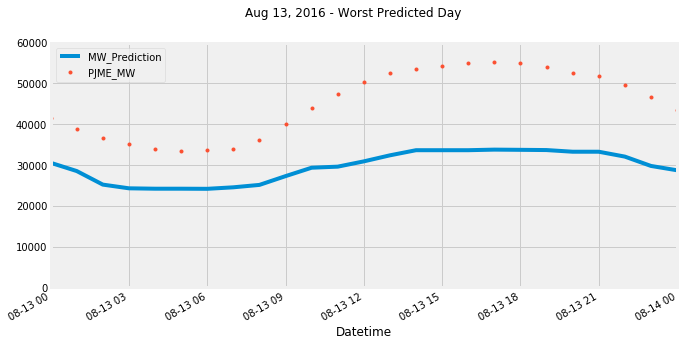

In [23]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

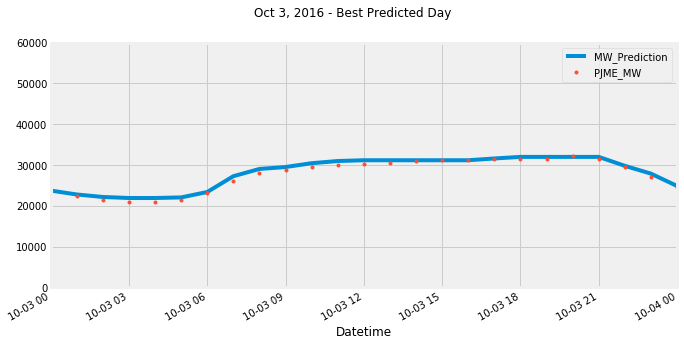

In [24]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

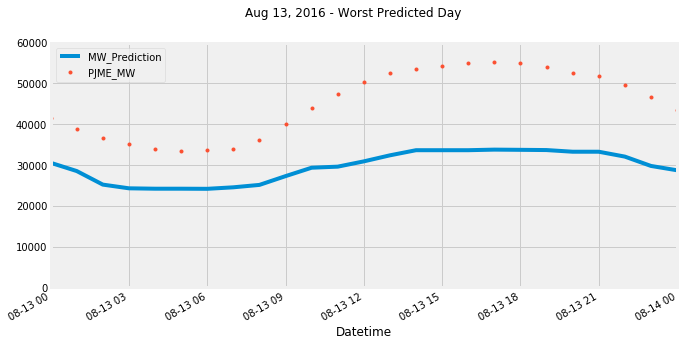

In [25]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')